<a href="https://colab.research.google.com/github/Disha200345/Fake-News-Detection-System/blob/main/Fake_news_detection_self.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Fake.csv to Fake.csv
Saving True.csv to True.csv


In [ ]:
fake_df = pd.read_csv("Fake.csv")[['text']]
fake_df['label'] = 0  # Fake

real_df = pd.read_csv("True.csv")[['text']]
real_df['label'] = 1  # Real

# Combine and shuffle
data = pd.concat([fake_df, real_df], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)

/tmp/ipython-input-3717745240.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_df['label'] = 1  # Real


In [ ]:
data['label'].value_counts()


,count
label,
0,23481
1,21417


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return " ".join([word for word in text.split() if word not in stop_words])

data['text'] = data['text'].apply(clean_text)

In [ ]:
X = data['text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization
vocab_size = 20000
max_len = 300
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.grid(False)
    plt.show()


In [ ]:
lstm_model = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#  Training
lstm_model.fit(X_train_pad, y_train, epochs=20, batch_size=128, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 164s 716ms/step - accuracy: 0.6673 - loss: 0.6190 - val_accuracy: 0.8694 - val_loss: 0.3776
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 204s 728ms/step - accuracy: 0.8823 - loss: 0.3510 - val_accuracy: 0.9188 - val_loss: 0.2624
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 199s 715ms/step - accuracy: 0.9164 - loss: 0.2701 - val_accuracy: 0.6258 - val_loss: 0.6029
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 203s 720ms/step - accuracy: 0.6335 - loss: 0.5710 - val_accuracy: 0.6506 - val_loss: 0.5529
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 202s 724ms/step - accuracy: 0.6587 - loss: 0.5286 - val_accuracy: 0.9269 - val_loss: 0.3330
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 202s 725ms/step - accuracy: 0.9544 - loss: 0.2005 - val_accuracy: 0.9745 - val_loss: 0.0978
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 192s 682ms/step - accuracy: 0.9819 - loss: 0.0892 - val_accuracy: 0.9823 - val_loss: 0.0628
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 156s 694ms/step - accuracy: 0.9903 -

In [ ]:
def evaluate_and_print(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n✅ {model_name} Performance:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    return acc, prec, rec, f1


In [ ]:
lstm_preds = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")


281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step


In [ ]:
evaluate_and_print(y_test, lstm_preds, "LSTM")



✅ LSTM Performance:
Accuracy:  0.9891
Precision: 0.9867
Recall:    0.9904
F1 Score:  0.9885


(0.989086859688196, 0.9866541793490986, 0.990364277320799, 0.9885057471264368)

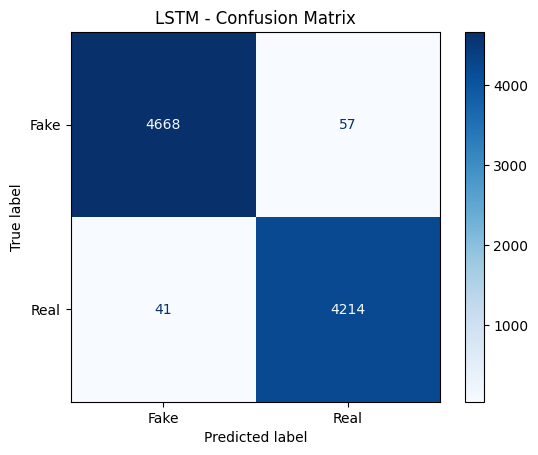

In [ ]:
plot_conf_matrix(y_test, lstm_preds, "LSTM")


In [ ]:
dnn_model = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#  Training
dnn_model.fit(X_train_pad, y_train, epochs=100, batch_size=128, validation_split=0.2)


Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.7828 - loss: 0.4683 - val_accuracy: 0.9791 - val_loss: 0.0856
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9801 - loss: 0.0757 - val_accuracy: 0.9883 - val_loss: 0.0514
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9868 - loss: 0.0429 - val_accuracy: 0.9904 - val_loss: 0.0365
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9962 - loss: 0.0189 - val_accuracy: 0.9912 - val_loss: 0.0325
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9984 - loss: 0.0108 - val_accuracy: 0.9928 - val_loss: 0.0291
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9989 - loss: 0.0070 - val_accuracy: 0.9904 - val_loss: 0.0351
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9803 - loss: 0.0451 - val_accuracy: 0.9919 - val_loss: 0.0313
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9911 - loss: 0.03

In [ ]:
def evaluate_and_print(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n✅ {model_name} Performance:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    return acc, prec, rec, f1


In [ ]:
dnn_preds = (dnn_model.predict(X_test_pad) > 0.5).astype("int32")

281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
evaluate_and_print(y_test, dnn_preds, "DNN")


✅ DNN Performance:
Accuracy:  0.9935
Precision: 0.9946
Recall:    0.9918
F1 Score:  0.9932


(0.9935412026726058,
 0.9945793070940372,
 0.9917743830787309,
 0.9931748646740409)

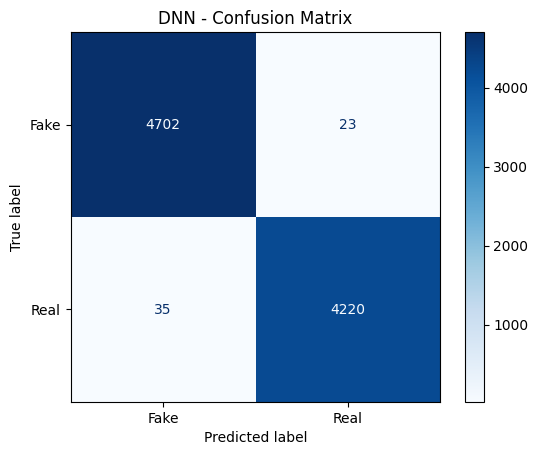

In [ ]:
plot_conf_matrix(y_test, dnn_preds, "DNN")

In [ ]:
cnn_lstm_model = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_lstm_model.fit(X_train_pad, y_train, epochs=20, batch_size=128, validation_split=0.2)
cnn_lstm_preds = (cnn_lstm_model.predict(X_test_pad) > 0.5).astype("int32")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 202s 877ms/step - accuracy: 0.7242 - loss: 0.5391 - val_accuracy: 0.9556 - val_loss: 0.1710
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 200s 868ms/step - accuracy: 0.6953 - loss: 0.6288 - val_accuracy: 0.9528 - val_loss: 0.1778
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 200s 864ms/step - accuracy: 0.9673 - loss: 0.1186 - val_accuracy: 0.9868 - val_loss: 0.0492
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 202s 866ms/step - accuracy: 0.9894 - loss: 0.0444 - val_accuracy: 0.9916 - val_loss: 0.0339
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 202s 864ms/step - accuracy: 0.9936 - loss: 0.0287 - val_accuracy: 0.9916 - val_loss: 0.0333
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 203s 870ms/step - accuracy: 0.9979 - loss: 0.0122 - val_accuracy: 0.9923 - val_loss: 0.0317
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 200s 861ms/step - accuracy: 0.9987 - loss: 0.0081 - val_accuracy: 0.9930 - val_loss: 0.0260
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 201s 858ms/step - accuracy: 0.9993 -

In [ ]:
evaluate_and_print(y_test, cnn_lstm_preds, "CNN-LSTM")


✅ CNN-LSTM Performance:
Accuracy:  0.9929
Precision: 0.9895
Recall:    0.9955
F1 Score:  0.9925


(0.9928730512249443,
 0.9894884372810091,
 0.9955346650998825,
 0.9925023430178069)

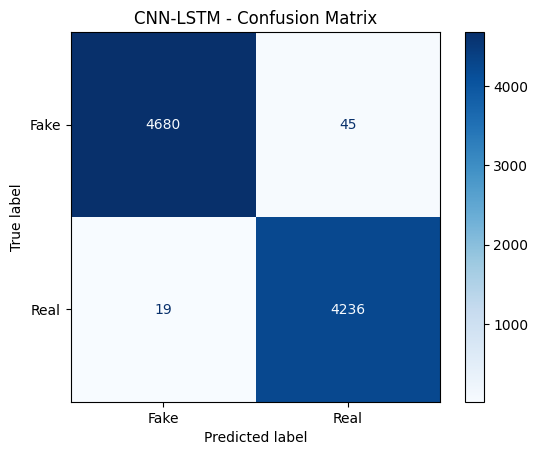

In [ ]:
plot_conf_matrix(y_test, cnn_lstm_preds, "CNN-LSTM")

In [ ]:
from transformers import create_optimizer

# Create optimizer using HuggingFace utility
batch_size = 16
epochs = 20
steps_per_epoch = len(X_train) // batch_size
num_train_steps = steps_per_epoch * epochs

optimizer, _ = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=0
)

bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [ ]:
# Use fewer samples for fast test
X_train_small = X_train[:500]
y_train_small = y_train[:500]

X_train_enc = encode_bert(X_train_small, tokenizer, max_len=64)
X_val_enc = encode_bert(X_val[:100], tokenizer, max_len=64)

# Change optimizer setup for fewer steps
batch_size = 16
epochs = 5
steps_per_epoch = len(X_train_small) // batch_size
num_train_steps = steps_per_epoch * epochs

optimizer, _ = create_optimizer(2e-5, num_train_steps, 0)

bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

bert_model.fit(
    x={
        'input_ids': X_train_enc['input_ids'],
        'attention_mask': X_train_enc['attention_mask']
    },
    y=np.array(y_train_small),
    validation_data=(
        {
            'input_ids': X_val_enc['input_ids'],
            'attention_mask': X_val_enc['attention_mask']
        },
        np.array(y_val[:100])
    ),
    batch_size=batch_size,
    epochs=epochs
)


Epoch 1/5
32/32 [==============================] - 479s 13s/step - loss: 0.0841 - accuracy: 0.9760 - val_loss: 0.0336 - val_accuracy: 0.9900
Epoch 2/5
32/32 [==============================] - 449s 14s/step - loss: 0.0132 - accuracy: 0.9980 - val_loss: 0.0147 - val_accuracy: 0.9900
Epoch 3/5
32/32 [==============================] - 442s 14s/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 0.9900
Epoch 4/5
32/32 [==============================] - 480s 15s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9900
Epoch 5/5
32/32 [==============================] - 440s 14s/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 0.9900


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_and_print(y_true, y_pred, model_name="Model"):
    print(f"\n🧪 Evaluation Report for {model_name}:\n")

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"✅ Accuracy:  {acc:.4f}")
    print(f"🎯 Precision: {prec:.4f}")
    print(f"🔁 Recall:    {rec:.4f}")
    print(f"📊 F1 Score:  {f1:.4f}")
    print("\n🧮 Confusion Matrix:\n", cm)

    print("\n📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))


In [ ]:
# Step 1: Predict
bert_preds_logits = bert_model.predict(
    [X_test_bert['input_ids'], X_test_bert['attention_mask']]
).logits

bert_preds = np.argmax(bert_preds_logits, axis=1)

# Step 2: Evaluate
evaluate_and_print(y_test, bert_preds, "BERT")


281/281 [==============================] - 4392s 16s/step

🧪 Evaluation Report for BERT:

✅ Accuracy:  0.9963
🎯 Precision: 0.9946
🔁 Recall:    0.9976
📊 F1 Score:  0.9961

🧮 Confusion Matrix:
 [[4702   23]
 [  10 4245]]

📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9979    0.9951    0.9965      4725
           1     0.9946    0.9976    0.9961      4255

    accuracy                         0.9963      8980
   macro avg     0.9962    0.9964    0.9963      8980
weighted avg     0.9963    0.9963    0.9963      8980



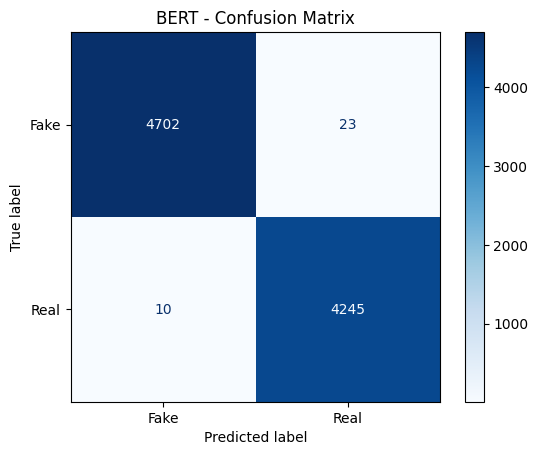

In [ ]:
plot_conf_matrix(y_test, bert_preds, "BERT")

In [ ]:
results = []  # Collect results for plotting

def evaluate_and_store(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n✅ {model_name} Performance:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })


In [ ]:
evaluate_and_store(y_test, lstm_preds, "LSTM")
evaluate_and_store(y_test, dnn_preds, "DNN")
evaluate_and_store(y_test, cnn_lstm_preds, "CNN-LSTM")
evaluate_and_store(y_test, bert_preds, "BERT")



✅ LSTM Performance:
Accuracy:  0.9891
Precision: 0.9867
Recall:    0.9904
F1 Score:  0.9885

✅ DNN Performance:
Accuracy:  0.9935
Precision: 0.9946
Recall:    0.9918
F1 Score:  0.9932

✅ CNN-LSTM Performance:
Accuracy:  0.9929
Precision: 0.9895
Recall:    0.9955
F1 Score:  0.9925

✅ BERT Performance:
Accuracy:  0.9963
Precision: 0.9946
Recall:    0.9976
F1 Score:  0.9961


In [ ]:
results_df = pd.DataFrame(results).set_index("Model")

In [ ]:
# Add average score
results_df["Average"] = results_df.mean(axis=1)

# Find the best model
best_model = results_df["Average"].idxmax()
best_score = results_df["Average"].max()

print(f"🏆 Best Model: {best_model} with average score of {best_score:.4f}")


🏆 Best Model: BERT with average score of 0.9962


/tmp/ipython-input-39-1160348878.py:21: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-39-1160348878.py:21: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


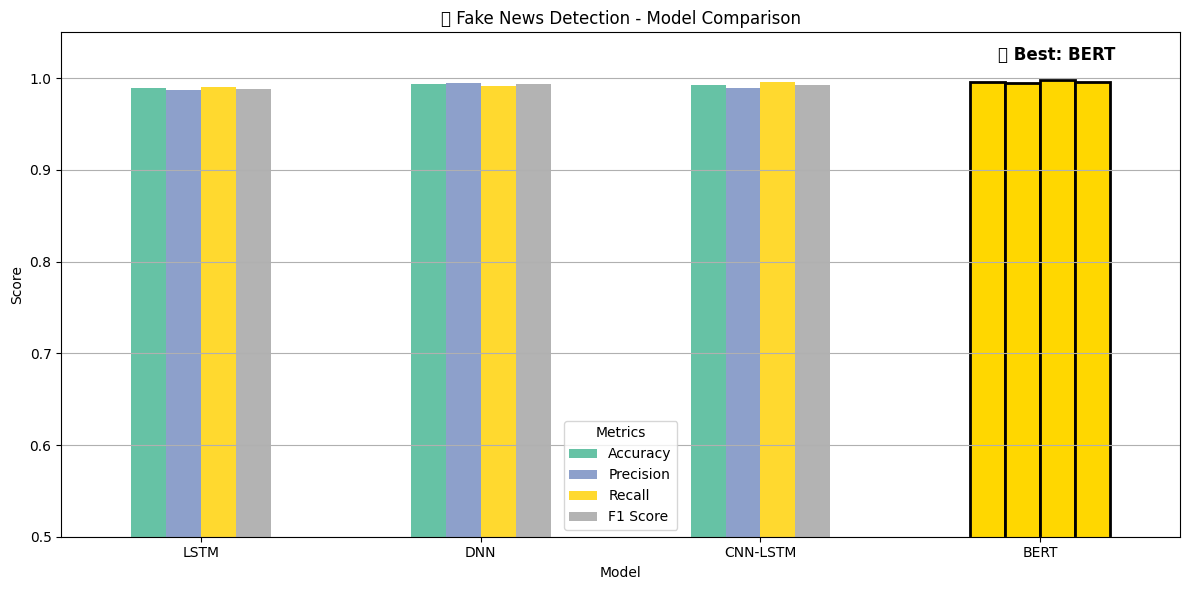

In [ ]:
# Plot all metrics
ax = results_df.drop(columns="Average").plot(kind='bar', figsize=(12, 6), colormap='Set2')
plt.title("🧪 Fake News Detection - Model Comparison")
plt.ylabel("Score")
plt.ylim(0.5, 1.05)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title="Metrics")

# Highlight best model
highlight_color = 'gold'
highlight_bar = results_df.index.get_loc(best_model)
for rect in ax.patches[highlight_bar::len(results_df)]:
    rect.set_edgecolor('black')
    rect.set_linewidth(2)
    rect.set_facecolor(highlight_color)

# Annotate best model
plt.text(highlight_bar - 0.15, 1.02, f"🏆 Best: {best_model}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
sample = [
    "The president resigns over fake scandal",
    "Aliens land in California, scientists confirm"
]

# Define labels for output
labels = ["Fake", "Real"]

# Preprocess for BERT
sample_inputs = encode_bert(sample, bert_tokenizer, 128)

# Predict using BERT
bert_pred_logits = bert_model.predict([sample_inputs['input_ids'], sample_inputs['attention_mask']]).logits
bert_pred = np.argmax(bert_pred_logits, axis=1)

# Display results
for i, label in enumerate(bert_pred):
    print(f"📰 \"{sample[i]}\" → Prediction: {labels[label]}")


1/1 [==============================] - 3s 3s/step
📰 "The president resigns over fake scandal" → Prediction: Real
📰 "Aliens land in California, scientists confirm" → Prediction: Fake
